In [ ]:
# ---------------
# Section 1: load data from SQL Server and create dataframes for plotting
# ---------------

library(tidyverse)
source("helpers.r")

# load expanded_df - this is 1 row per website session.
con <- connect_to_db()
expanded_df <- collect(tbl(con, "dataExpanded")) %>%
    mutate(date_id = as.Date(date_id, format = "%d/%m/%Y"))
DBI::dbDisconnect(con)

# calculate aggregated_df - this is equivalent to the csv file provided by Trade Me (one row per day per treament group per outcome)
aggregated_df <- expanded_df %>%
    group_by(date_id, group_id, session_result) %>%
    summarise(session_count = length(session_result))

# calculate conversion rates
conv_rate_data <- aggregated_df %>%
    pivot_wider(names_from = session_result, values_from = session_count) %>%
    transmute(date_id, group_id, n = `0` + `1`, conversions = `1`, conversion_rate = `1` / (`0` + `1`))

# add in a final "OVERALL" group that aggregates values across all days
expanded_df_overall <- expanded_df %>%
    mutate(date_id = "OVERALL")
expanded_df_combined <- expanded_df %>%
    mutate(date_id = as.character(date_id)) %>%
    bind_rows(expanded_df_overall)
conv_rate_data_overall <- conv_rate_data %>%
    group_by(group_id) %>%
    summarise(n = sum(n), conversions = sum(conversions)) %>%
    mutate(conversion_rate = conversions / n) %>%
    mutate(date_id = "OVERALL")
conv_rate_data_combined <- bind_rows(
    mutate(conv_rate_data, date_id = as.character(date_id)), conv_rate_data_overall
    )
# calculate conf intervals for conversion rates
ci_data <- Hmisc::binconf(x = conv_rate_data_combined$conversions, n = conv_rate_data_combined$n, return.df = TRUE)
conv_rate_data_combined <- bind_cols(conv_rate_data_combined, ci_data)

`summarise()` has grouped output by 'date_id', 'group_id'. You can override
using the `.groups` argument.


In [ ]:
print(head(expanded_df, 3))

# A tibble: 3 × 4
  date_id    group_id session_result session_id
  <date>     <chr>             <int>      <int>
1 2018-06-25 A                     0          1
2 2018-06-25 A                     0          2
3 2018-06-25 A                     0          3


In [28]:
print(head(aggregated_df, 3))

# A tibble: 3 × 4
# Groups:   date_id, group_id [2]
  date_id    group_id session_result session_count
  <date>     <chr>             <int>         <int>
1 2018-06-25 A                     0           763
2 2018-06-25 A                     1          3597
3 2018-06-25 B                     0           777


In [34]:
print(head(conv_rate_data_combined, 3))

# A tibble: 3 × 8
# Groups:   date_id, group_id [3]
  date_id    group_id     n conversions conversion_rate PointEst Lower Upper
  <chr>      <chr>    <int>       <int>           <dbl>    <dbl> <dbl> <dbl>
1 2018-06-25 A         4360        3597           0.825    0.825 0.813 0.836
2 2018-06-25 B         4328        3551           0.820    0.820 0.809 0.832
3 2018-06-26 A         4047        3353           0.829    0.829 0.817 0.840


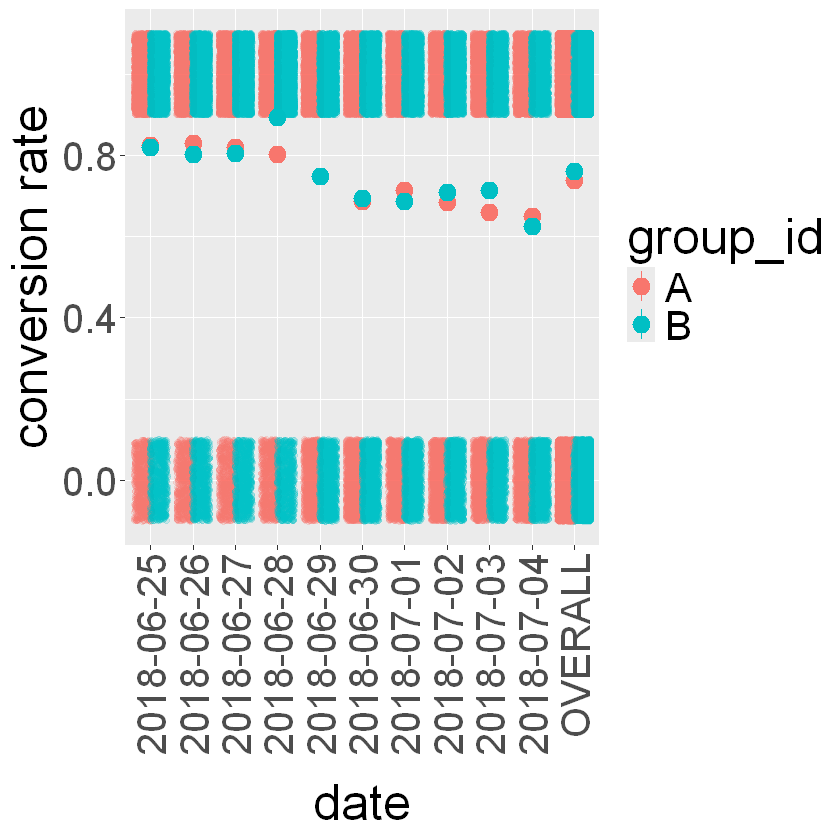

In [ ]:


# create plot: scatterplot of raw data (one row per session) with conversion rate and confidence intervals overlaid
p4 <- sql_expanded_combined %>%
# sample_n(5000) %>%
    ggplot(aes(date_id, session_result, colour = group_id)) +
    geom_jitter(alpha = 0.15, position = position_jitterdodge(jitter.height = 0.1)) + 
    geom_pointrange(
    data = conv_rate_data_combined,
    aes(x = date_id, y = PointEst, ymin = Lower, ymax = Upper, colour = group_id),
    size = 1
  ) + xlab("date") + ylab("conversion rate") +
  theme(
    text = element_text(size = 30),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave("conv rate by group.png", p4, width = 15, height = 15)
print(p4)


In [ ]:


# weekday effect? Nothing major. Biggest diff is Thurs. BUT only covers 10d so hard to analyse fully.
p10 <- conv_rate_data %>%
    mutate(dow = wday(date_id, label = TRUE, abbr = FALSE, week_start = 1)) %>%
    ggplot(aes(dow, conversion_rate, colour = group_id)) +
    geom_point(size = 5) +
  theme(
    text = element_text(size = 30),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
# print(p10)
ggsave("conv rate by dow.png", p10, width = 15, height = 15)

# what about differences in proportions? 
dfs_list_by_date <- conv_rate_data_combined %>%
    group_by(date_id) %>%
    group_split()
conv_rate_diffs_df <- map_df(dfs_list_by_date, calc_ci_for_diff_of_propns)

p5 <- conv_rate_diffs_df %>% 
ggplot(aes(date_id, point_estimate_diff)) +
    geom_pointrange(
        data = conv_rate_diffs_df,
        aes(x = date_id, y = point_estimate_diff, ymin = lower_ci_diff, ymax = upper_ci_diff),
        size = 1
    ) + 
    geom_abline(slope = 0, intercept = 0, colour = "red") + xlab("date") + ylab("difference in conversion rate (A minus B)") +
  theme(
    text = element_text(size = 30),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
# print(p5)
ggsave("conv_rate_diffs.png", p5, height = 15, width = 15)

# anything interesting in terms of conversion rate or website usage over time?
p6 <- aggregated_df %>%
    mutate(
        session_result = ifelse(session_result == 1, "sessions that converted", "sessions that didnt convert")
    ) %>%
    bind_rows(aggregated_df %>%
        group_by(date_id, group_id) %>%
        summarise(session_count = sum(session_count)) %>%
        mutate(session_result = "total sessions")) %>%
    ggplot(aes(date_id, session_count, colour = group_id)) +
    geom_line() +
    facet_wrap(~session_result, ncol = 1) +
    theme(
        text = element_text(size = 30),
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)
    )
ggsave("sessions_over_time.png", p6, height = 15, width = 15)